## Assignment A3. Pitch and Rhythm

The goal of this assignment is the exploration of classic algorithms (e.g. autocorrelation, DFT-based) to extract fundamental information from musical signals:
- Pitch (in monophonic signals)
- Beats and Tempo;

In [43]:
%matplotlib inline
import numpy, scipy, matplotlib.pyplot as plt, IPython.display as ipd
import librosa, librosa.display
import matplotlib.pyplot as plt

In [4]:
x, sr = librosa.load('oboe.wav')
ipd.Audio(x, rate=sr)

In [5]:
print(sr)

22050


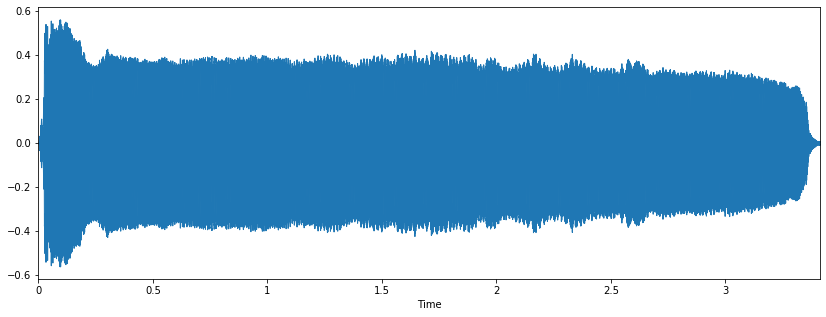

In [6]:
plt.figure(figsize=(14, 5))
librosa.display.waveplot(x, sr)

In [7]:
x2, sr2 = librosa.load('organ.wav')
ipd.Audio(x2, rate=sr2)

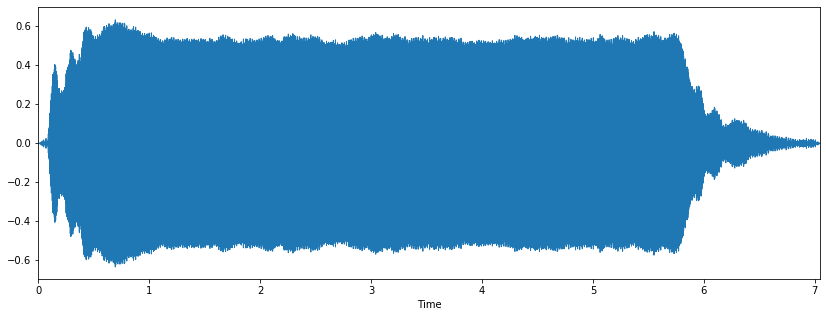

In [8]:
plt.figure(figsize=(14, 5))
librosa.display.waveplot(x2, sr2)

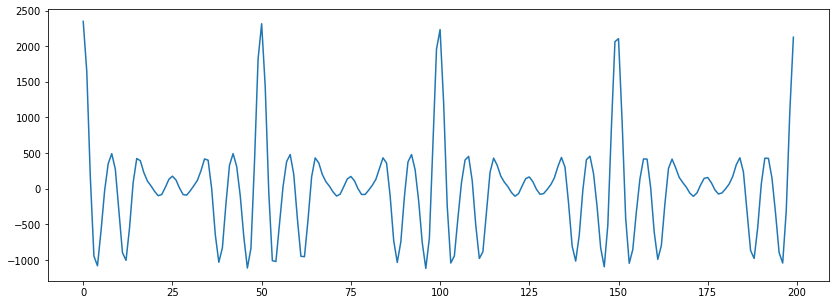

In [9]:
r = librosa.autocorrelate(x, max_size=5000)
plt.figure(figsize=(14, 5))
plt.plot(r[:200])

## Oboe

The autocorrelation always has a maximum at zero, i.e. zero lag. We want to identify the maximum outside of the peak centered at zero. Therefore, we might choose only to search within a range of reasonable pitches:

In [10]:
midi_hi = 120.0
midi_lo = 12.0
f_hi = librosa.midi_to_hz(midi_hi)
f_lo = librosa.midi_to_hz(midi_lo)
t_lo = sr/f_hi
t_hi = sr/f_lo

In [11]:
print(f_lo, f_hi)
print(t_lo, t_hi)

16.351597831287414 8372.018089619156
2.633773573344376 1348.4920695523206


Set invalid pitch candidates to zero:

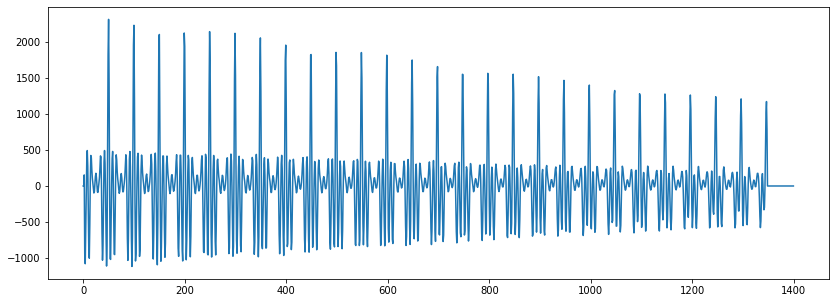

In [12]:
r[:int(t_lo)] = 0
r[int(t_hi):] = 0
plt.figure(figsize=(14, 5))
plt.plot(r[:1400])

Find the location of the maximum:

In [13]:
t_max = r.argmax()
print(t_max)

50


Finally, estimate the pitch in Hertz:

In [14]:
float(sr)/t_max

441.0

Value coresponds to A4 (69), source: https://musicinformationretrieval.com/midi_conversion_table.html

In [15]:
librosa.midi_to_hz(69)

440.0

## Organ

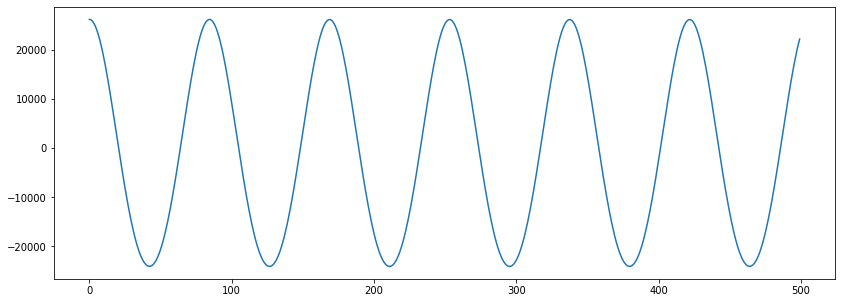

In [16]:
r2 = librosa.autocorrelate(x2, max_size=5000)
plt.figure(figsize=(14, 5))
plt.plot(r2[:500])

In [17]:
print(r2)

[26296.236   26213.191   25964.986   ...  -408.46164 -2242.559
 -4049.1738 ]


In [18]:
midi_hi = 120.0
midi_lo = 12.0
f_hi = librosa.midi_to_hz(midi_hi)
f_lo = librosa.midi_to_hz(midi_lo)
t_lo = sr2/f_hi
t_hi = sr2/f_lo

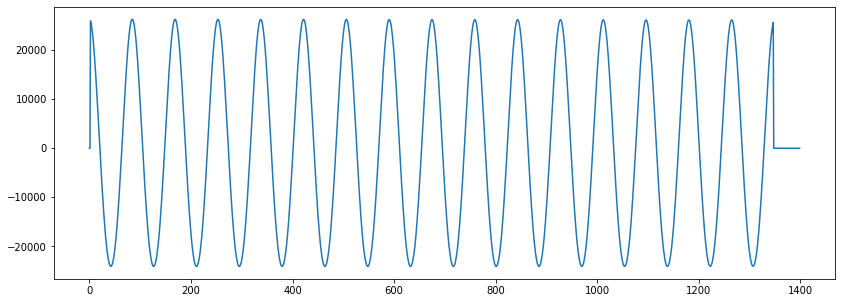

In [19]:
r2[:int(t_lo)] = 0
r2[int(t_hi):] = 0
plt.figure(figsize=(14, 5))
plt.plot(r2[:1400])

In [20]:
t_max2 = r2.argmax()
print(t_max)

50


In [21]:
pitch = float(sr)/t_max2

In [22]:
midi_rep = librosa.hz_to_midi(pitch)

In [23]:
note = librosa.midi_to_note(midi_rep)
print(note)

C4


Value coresponds to C4 (60), source: https://musicinformationretrieval.com/midi_conversion_table.html

In [24]:
librosa.midi_to_hz(60)

261.6255653005986

### Is this value correct or incorrect?
To verify the results, we opened to sonic visuliser and we analyzed the files. Here are results:
#### Oboe
![Chromagram of oboe](oboe_chrom.PNG "Oboe")
Chromagram for oboe shows notes A + A# which corresponds with computed notes.

#### Organ
![Chromagram of organ](organ_chrom.PNG "Organ")
Chromagram for oboe shows notes B+C+C# which also corresponds with computed notes.

### Global Analysis
On the previous task, your pitch estimates were frame-based. For the same signals, extend this frame analysis to the full sound, and for each sound:
 1. obtain a plot of the pitch estimation; on the x-axis you’ll have the frame number, on the y-axis the pitch/f0 in Hz.
 2. obtain a plot of the pitch estimation; on the x-axis you’ll have the frame number, on the y-axis the pitch/f0 in MIDI Note (ex. A0, B0, B1)
 3. Is any of these representations ( 1) or 2) ) a chromagram? Explain your answer.

In [38]:
def pitch_detection_in_frames(x, frame_length=2048, hop_length=512):
    frames = librosa.util.frame(x, frame_length=frame_length, hop_length=hop_length); #2048
    total_frames, num_of_values_in_frame = frames.shape;
    pitch_arr_hz = []
    pitch_arr_midi = []
    for i in range(total_frames):
        pitch_max = frames[i].argmax() # counting the pitch for each frame
        if (pitch_max == 0):
            pitch_arr_hz.append(0)
            pitch_arr_midi.append(0)
        else:
            pitch_hz = float(sr)/pitch_max
            pitch_arr_hz.append(pitch_hz) # creating the array with pitches
            midi_rep = librosa.hz_to_midi(pitch_hz)
            pitch_arr_midi.append(midi_rep)

    plt.figure(figsize=(14, 5))
    plt.plot(pitch_arr_hz, 'ro')
    plt.xlabel("frame")
    plt.ylabel("Hz")
    
    plt.figure(figsize=(14, 5))
    plt.plot(pitch_arr_midi,  'ro') # it look better with the points but we can delete this parameter
    plt.xlabel("frame")
    plt.ylabel("MIDI")

#### Pitch detection for oboe

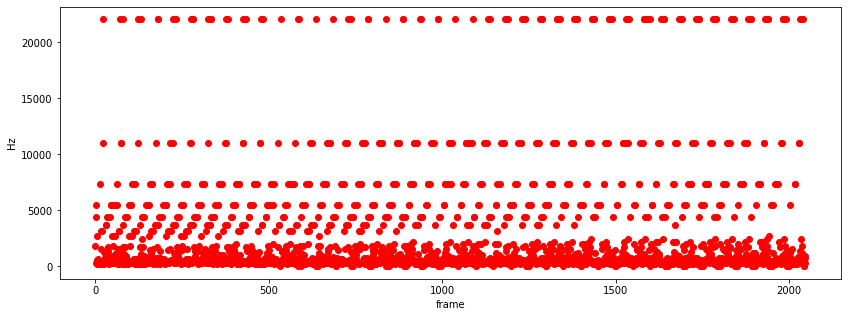

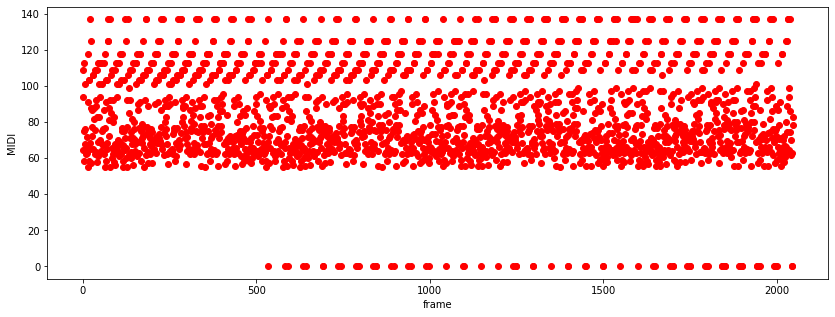

In [39]:
pitch_detection_in_frames(x) #@todo discuss frame + hop

#### Pitch detection for organ

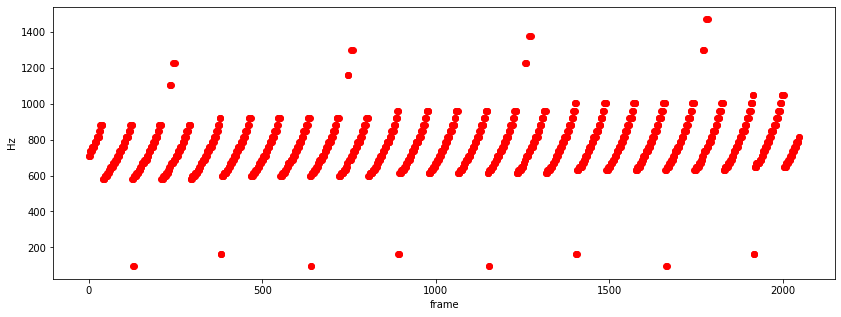

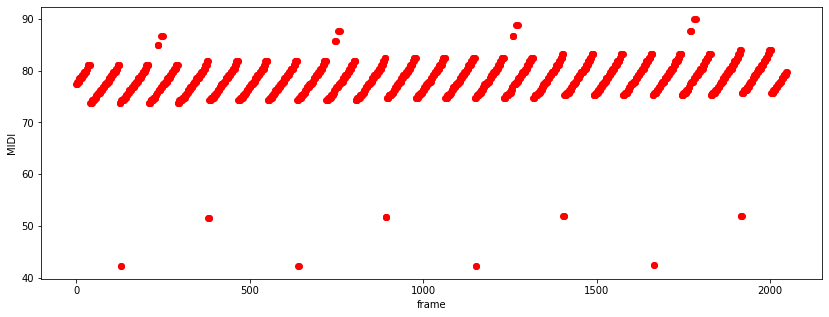

In [40]:
pitch_detection_in_frames(x2)

#### Is any of these representations ( 1) or 2) ) a chromagram? Explain your answer.
maybe we will find out by changing the frame size ...

### Task 2 – Rhythm
As you've seen, the ACF may be used to estimate the periodicity of a signal. Last week, I asked you to think about other main characteristics of the music signals may be characterised by periodicities, and if it would make sense to use the autocorrelation function for those potential tasks. I assume you already know the answer: yes!


In [41]:
x3, sr3 = librosa.load('rhythm.wav')
ipd.Audio(x3, rate=sr3)

In [51]:
def beats(x, sr):
    # Track beats using a pre-computed onset envelope
    onset_env = librosa.onset.onset_strength(x, sr=sr, aggregate=numpy.median)
    '''
            1. Measure onset strength
            2. Estimate tempo from onset correlation
            3. Pick peaks in onset strength approximately consistent with estimated tempo
    '''
    tempo, beats = librosa.beat.beat_track(onset_envelope=onset_env,sr=sr)
    hop_length = 512
    plt.figure(figsize=(8, 4))
    times = librosa.times_like(onset_env, sr=sr, hop_length=hop_length)
    plt.plot(times, librosa.util.normalize(onset_env),label='Onset strength')
    plt.vlines(times[beats], 0, 1, alpha=0.5, color='r', linestyle='--', label='Beats')
    #print(times[beats])
    plt.legend(frameon=True, framealpha=0.75)
    # Limit the plot to a 15-second window
    plt.xlim(0, 9)
    plt.gca().xaxis.set_major_formatter(librosa.display.TimeFormatter())
    plt.tight_layout()
    plt.show()
    
    # clicks at beat times
    times = librosa.frames_to_time(beats, sr=sr)
    y_beat_times = librosa.clicks(times=times, sr=sr,length=len(x))
    #clicks = librosa.clicks(frames=beats, sr=sr, length=len(x))
    return y_beat_times

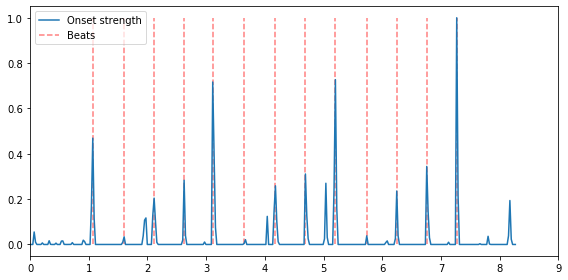

In [52]:
clicks = beats(x3, sr3)
#print(clicks)
ipd.Audio(x3 + clicks, rate=sr3)

#### Do a subjective evaluation on the quality of the beat tracking.
I think the quality is very good. I don't hear any deviation.

#### This rhythm shows a steady constant tempo. Obtain the global tempo estimative in bpm (you can do it by hand, no need to code it).
My estimation:
BMP = Beats per minute 
13 clicks in 6.7 sec => 117 BMP

In [60]:
60/6.65*13

117.29323308270678

In [61]:
# just to verify
onset_env = librosa.onset.onset_strength(x3, sr=sr3)
librosa.beat.tempo(onset_envelope=onset_env, sr=sr3)

array([117.45383523])

#### How many downbeats are in this musical example? At what times?
downbeat = the first beat of each bar
I really don't see these grapfs so helpful because the loudness here does not correspond to the downbeat as this rhytm does not follow this rule. From my point of view:
There are 2 downbeats (in 0 and 4,2).

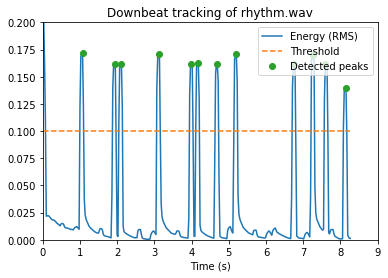

In [63]:
# https://github.com/librosa/librosa/issues/1065
# detecting downbeats according to louness
import librosa
import matplotlib
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import os
import scipy.signal

threshold = 0.1
hop_length = 512
input_path = 'rhythm.wav'

y, sr = librosa.load(input_path, sr=None)
rms = librosa.feature.rms(y, hop_length=hop_length)[0, :]
peak_locs = scipy.signal.find_peaks(rms, height=threshold)[0]
peak_heights = rms[peak_locs]

times = librosa.times_like(rms, hop_length=hop_length, sr=sr)
plt.plot(times, rms, label="Energy (RMS)");
plt.plot(times, threshold*np.ones_like(rms), '--', label="Threshold")
plt.plot(times[peak_locs], peak_heights, 'o', label="Detected peaks")

plt.xlim(0, np.ceil(librosa.get_duration(y, sr)))
plt.xlabel("Time (s)")
plt.ylim(0, 2*threshold)
plt.title("Downbeat tracking of {}".format(os.path.split(input_path)[1]))
plt.legend()

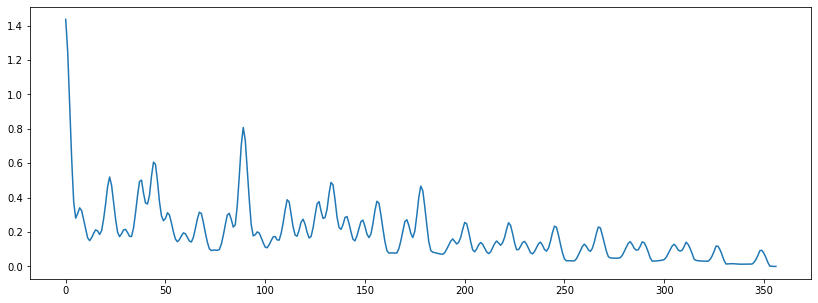

In [66]:
# What would you obtain if you applied the autocorrelation function to this novelty function
rm_auto = librosa.autocorrelate(rms, max_size=5000)
plt.figure(figsize=(14, 5))
plt.plot(rm_auto[:2000])

In [64]:
#https://stackoverflow.com/questions/57384448/detecting-beat-energy-with-librosa-finding-the-first-beat-of-each-bar
import numpy as np

y, sr = librosa.load('rhythm.wav')
# get onset envelope
onset_env = librosa.onset.onset_strength(y, sr=sr, aggregate=np.median)
# get tempo and beats
tempo, beats = librosa.beat.beat_track(onset_envelope=onset_env, sr=sr)
# we assume 4/4 time
meter = 4
# calculate number of full measures 
measures = (len(beats) // meter)
# get onset strengths for the known beat positions
# Note: this is somewhat naive, as the main strength may be *around*
#       rather than *on* the detected beat position. 
beat_strengths = onset_env[beats]
# make sure we only consider full measures
# and convert to 2d array with indices for measure and beatpos
measure_beat_strengths = beat_strengths[:measures * meter].reshape(-1, meter)
# add up strengths per beat position
beat_pos_strength = np.sum(measure_beat_strengths, axis=0)
# find the beat position with max strength
downbeat_pos = np.argmax(beat_pos_strength)
# convert the beat positions to the same 2d measure format
full_measure_beats = beats[:measures * meter].reshape(-1, meter)
# and select the beat position we want: downbeat_pos
downbeat_frames = full_measure_beats[:, downbeat_pos]
print('Downbeat frames: {}'.format(downbeat_frames))
# print times
downbeat_times = librosa.frames_to_time(downbeat_frames, sr=sr)
print('Downbeat times in s: {}'.format(downbeat_times))


Downbeat frames: [ 46 134 224]
Downbeat times in s: [1.06811791 3.11147392 5.20126984]


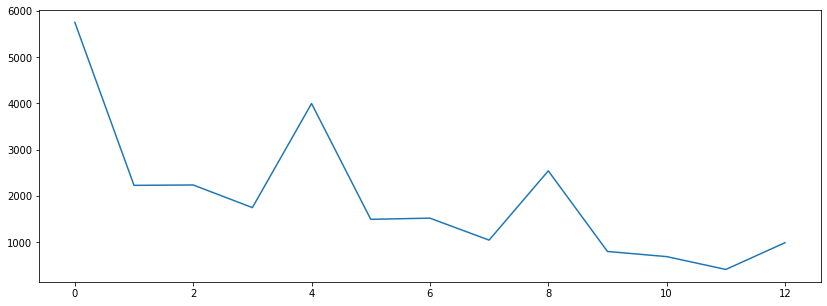

In [67]:
# What would you obtain if you applied the autocorrelation function to this novelty function
beat_auto = librosa.autocorrelate(beat_strengths, max_size=5000)
plt.figure(figsize=(14, 5))
plt.plot(beat_auto[:2000])

#### What is the novelty function that you used? (i.e., the library implements). What functions do you know that could be used for the same end?
- librosa.feature.rms, librosa.beat.beat_track
Some functions that counts loudness, energy etc.

#### What would you obtain if you applied the autocorrelation function to this novelty function? Explain your answer.
Decreasing shape. Don't know why so far.

### Task 3 – Pitch and Rhythm I
Download voice.wav. This music excerpt contains 9 notes (part of a musical scale), singed by a feminine voice. With the help of Sonic Visualiser, answer the following:

#### What is the chroma and height of the 9 notes?
I probably dont know how to set the chromagram, but the notes are definitely like this (I played them on piano):
A, H, C#, D, E, D, C#, H, A

![Chromagram of voice](voice_chrom.PNG "Voice")

#### Assuming each note represents a beat, what is the tempo (in bpm) of this excerpt.
it has 8 seconds and there are 9 notes => 67,5 BPM 

In [70]:
60/8*9

67.5

### Task 4 – Pitch and Rhythm II
Hint: You already have most of the code needed for this to work. For a quick fix to obtain the expected result you’ll need to add the following:
- Choose the frames in which you have to estimate the pitch (exclude the silences).
- Choose a way to average the estimates for each note across the different frames.
